In [0]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-psoq17ln
  Running setup.py bdist_wheel for NVCCPlugin ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-jza6turh/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [0]:
%load_ext nvcc_plugin
%pylab inline

created output directory at /content/src
Out bin /content/result.out
Populating the interactive namespace from numpy and matplotlib


In [0]:
! wget -q -O screen.jpg https://imgur.com/GJceFkD.jpg
from google.colab import files
from IPython.display import Image, display, HTML
# display(HTML("<img src='https://imgur.com/C0FmDKZ.jpg'>"))
# Image("screen.jpg", width=400)

In [0]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <curand_kernel.h>
#include <fstream>
#include <iostream>
#include <math.h>
#include <stdlib.h>
#include <time.h>

#include <math.h>
#define SCALE 2.0
#define SHIFT 4.5
#define DISCRETE
#define BLOCKS 1024
//First of all, your thread block size should always be a multiple of 32
#define THREADS 512
using namespace std;

#define CUDA_CALL(x) do { if((x) != cudaSuccess) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__); \
    return EXIT_FAILURE;}} while(0)

// ------------------------------------------
__device__ double V_func(double x, double par0, double par1, double par2){
    return par0 * par1 * 14.4 / x * par2;
}

__device__ double Vshtrih_func(double x, double par0, double par1, double par2, double par3, double par4) {
    return par0 * par1 * 14.4 / x * (par2 / par3 - par4 / x);
}

__device__ double FI_func(double x) {
    return 0.1818 * exp(-3.2 * x) + 0.5099 * exp(-0.9432 * x) + 0.2802 * exp(-0.4029 * x) + 0.0282 * exp(-0.2016 * x);
}
__device__ double FIshtrih_func(double x) {
    return -(0.1818 * 3.2 * exp(-3.2 * x) + 0.5099 * 0.9432 * exp(-0.9432 * x) + 0.2802 * 0.4029 * exp(-0.4029 * x) + 0.0282 * 0.2016 * exp(-0.2016 * x));
}

__device__ double f_func(double x, double par0, double par1, double par2) {
    return 1 - par0 / par1 - (par2 / x) * (par2 / x);
}

__device__ double fshtrih_func(double x, double par0, double par1, double par2) {
    return -par0 / par1 + 2 * par2 * par2 / (x * x * x);
}

__device__ double sinkvtetanadva(double p, double E, double M1, double M2, int Z1, int Z2) {
    double a = 0.88534 * 0.529 / (pow(Z1, 0.23) + pow(Z2, 0.23));
    a = a * (-0.003 * (pow(Z1, 0.5) + pow(Z2, 0.5)) + 0.98);

    double B = p / a;
    double Ec = E / (1 + M1 / M2);

    double rm = a;
    double V_out;
    double Vshtrih_out;
    for (int gggg = 0; gggg < 20; gggg++) {
        double FI_out = FI_func(rm / a);
        double FIshtrih_out = FIshtrih_func(rm / a);
        V_out = V_func(rm, Z1, Z2, FI_out);
        Vshtrih_out = Vshtrih_func(rm, Z1, Z2, FIshtrih_out, a, FI_out);
        double fshtrih_out = fshtrih_func(rm, Vshtrih_out, Ec, p);
        double f_out = f_func(rm, V_out, Ec, p);
        rm = rm - f_out / fshtrih_out;
    }
    double ro = -2 * (Ec - V_out) / Vshtrih_out;
    double Rm = rm / a;
    double Rc = ro / a;
    double Esm = M2 / (M1 + M2) * E;
    double epsilon = a * Esm / (Z1 * Z2 * 14.4);
    double alfa = 1 + 0.75984 * pow(epsilon, -0.5);
    double beta = (5.71974 + pow(epsilon, 0.5)) / (6.14171 + pow(epsilon, 0.5));
    double gamma = (9.5217 + epsilon) / (6.2612 + epsilon);
    double A = 2 * alfa * epsilon * pow(B, beta);
    double G = gamma / (powf((1 + A * A), 0.5) - A);

    double delta = A * (Rm - B) / (1 + G);

    if (((B + Rc + delta) / (Rm + Rc) < 1) && ((B + Rc + delta) / (Rm + Rc) > -1)) {
        double theta = 2 * acosf((B + Rc + delta) / (Rm + Rc));
        return (sinf(theta / 2) * sinf(theta / 2));
    } else {
        return 1 / (1 + 2 * epsilon * B * 2 * epsilon * B);
    }
}
//-----------------------------------------------

__global__ void setup_kernel(curandState *state)
{
    int id = threadIdx.x + blockIdx.x * blockDim.x;
    /* Each thread gets different seed, a different sequence
       number, no offset */
    curand_init(7+id, id, 0, &state[id]);
}


__global__ void generate_kernel(curandState *state,
                                float *result)
{   
    int id = threadIdx.x + blockIdx.x * blockDim.x;
    //float x = 0;
    /* Copy state to local memory for efficiency */
    curandState localState = state[id];
    
    double M1 = 4, Z1 = 2, E = 150; //aem,keV
    int n = 3;
    double M1m = 12, Z1m = 6; //aem,г/моль
    double M2m = 1, Z2m = 1; //aem,г/моль
    double M3m = 16, Z3m = 8; //aem,г/моль/
    double w[100] = {
        12. / 37,
        18. / 37,
        7. / 37
    };
    double mu[100] = {
        12,
        1,
        16
    };
    double ro = 1.32;
    double x0 = 0, y0 = 0, z0 = 0;
    double omegaX1 = 1, omegaY1 = 0, omegaZ1 = 0;
    double omegaX2, omegaY2, omegaZ2;
    double Na = 6.02e23;

    double Mu = 0;

    for (int ta = 0; ta < n; ta++) {
        Mu = Mu + w[ta] * mu[ta];
    }
    double n0 = ro / Mu * Na;

    double L = pow(n0, -1. / 3);

    double ksi;
    double M2, Z2;
    double x, y, z;

    int k = 0;
    int z1mi = 0;
    int z2mi = 0;
    int z3mi = 0;
    double length = 0;
    while (E > 10) {

        double wpar[100];
        wpar[0] = w[0];

        for (int i = 1; i < n; i++) {
            wpar[i] = wpar[i - 1] + w[i];
        }
        
        // -------UNIFORM-----------------
        double ksi = (curand_uniform(&localState));

        int k = 0;
        while (ksi > wpar[k]) k++;

        int prtn = k;

        if (prtn == 0) {
            Z2 = Z1m;
            M2 = M1m;
            z1mi++;
        }
        if (prtn == 1) {
            Z2 = Z2m;
            M2 = M2m;
            z2mi++;
        }
        if (prtn == 2) {
            Z2 = Z3m;
            M2 = M3m;
            z3mi++;
        }
        // -------UNIFORM-----------------
        ksi = (curand_uniform(&localState));
        
        double p = sqrt(ksi / 3.1415 / pow(n0, 2. / 3)) * 1e8;

        double Emax = 4 * M1 * M2 / pow((M1 * M2), 2) * E;
        double skt = sinkvtetanadva(p, E, M1, M2, Z1, Z2);
        
        double teta = 2 * asin(sqrt(skt));
        double E2 = Emax * skt;

        double alfa = 1.88 / 1000 * pow(Z1 + Z2, 5. / 3) * sqrt(E / M1);
        double beta = 0.3042 * pow((Z1 + Z2), 1. / 3);
        double deltaE = alfa / pow(1 + beta * p, 5);

        double Tetalab = atan(sin(teta) / (cos(teta) + M1 / M2));
        double muuuu = cos(Tetalab);
        
        // -------UNIFORM-----------------
        ksi = curand_uniform(&localState);

        double fi = 2 * 3.1415 * ksi;

        omegaX2 = omegaX1 * muuuu - (omegaY1 * sin(fi) + omegaX1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaY2 = omegaY1 * muuuu + (omegaX1 * sin(fi) - omegaY1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaZ2 = omegaZ1 * muuuu + (1 - omegaZ1 * omegaZ1) * cos(fi) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);

        x = L * omegaX2 + x0;
        y = L * omegaY2 + y0;
        z = L * omegaZ2 + z0;

        k++;

        x0 = x;
        y0 = y;
        z0 = z;
        
        length += sqrt(x*x+y*y+z*z);

        omegaX1 = omegaX2;
        omegaY1 = omegaY2;
        omegaZ1 = omegaZ2;

        E = E - E2 - deltaE;
        
    }
    /* Generate pseudo-random uniforms
    for(int n = 0; n < 10; n++) {
        x = (curand_uniform(&localState));
    }
     Copy state back to global memory */
    state[id] = localState;
    /* Store last generated result per thread */
    double translation = sqrt(x*x+y*y+z*z);
    result[id] = translation;
    //result[id] = length;
}


int main(int argc, char *argv[])
{
    int i;
    unsigned int total;
    curandState *devStates;
    float *devResults, *hostResults;
    int device;
    struct cudaDeviceProp properties;

    CUDA_CALL(cudaGetDevice(&device));
    CUDA_CALL(cudaGetDeviceProperties(&properties,device));


    /* Allocate space for results on host */
    hostResults = (float *)calloc(THREADS * BLOCKS, sizeof(float));

    /* Allocate space for results on device */
    CUDA_CALL(cudaMalloc((void **)&devResults, BLOCKS * THREADS *
              sizeof(float)));
    /* Set results to 0 */
    CUDA_CALL(cudaMemset(devResults, 0, THREADS * BLOCKS *
              sizeof(float)));

    /* Allocate space for prng states on device */
    CUDA_CALL(cudaMalloc((void **)&devStates, THREADS * BLOCKS *
                  sizeof(curandState)));
    
    bool time_profiling = true;
    //------------TIME------------------------
    if(time_profiling){
    
    int n = 20;
    int step = 128; //step
    float *times = new float[n];
    int *ns = new int[n];
    int count = 0;
    
    ofstream myfile2;
    myfile2.open ("gpu_times_10.txt");
    myfile2 << n<<endl<<step<<endl;
    clock_t t;
    
    for (int i=0; i<step*n; i+=step){
        t = clock();
        /* Allocate space for results on host */
        hostResults = (float *)calloc((count+1)*n, sizeof(float));

        /* Allocate space for results on device */
        CUDA_CALL(cudaMalloc((void **)&devResults, (count+1)*n *
              sizeof(float)));
        /* Set results to 0 */
        CUDA_CALL(cudaMemset(devResults, 0, (count+1)*n *
              sizeof(float)));

        /* Allocate space for prng states on device */
        CUDA_CALL(cudaMalloc((void **)&devStates, (count+1)*n*
                  sizeof(curandState)));
        /* Setup prng states */
        setup_kernel<<<(count+1), n>>>(devStates);
    
        /* Generate and use uniform pseudo-random  */
        generate_kernel<<<(count+1), n>>>(devStates, devResults);
    
        /* Copy device memory to host */
        CUDA_CALL(cudaMemcpy(hostResults, devResults, (count+1)*n *
        sizeof(float), cudaMemcpyDeviceToHost));
        
        t = clock() - t;
        times[count] = ((float)t)/CLOCKS_PER_SEC;
        myfile2 <<times[count]<<endl;
        ns[count] = i;
        count++;
    }
    myfile2.close();
    
    /*for (int i=1; i<nn; i*=2){
        cout<<i;
        times[count] = ((float)time_profiling(i))/CLOCKS_PER_SEC;
        ns[count] = i;
        cout<<times[count];
        count++;
    }*/
    delete [] ns;
    delete [] times;
    CUDA_CALL(cudaFree(devStates));
    CUDA_CALL(cudaFree(devResults));
    free(hostResults);
    return 0;}
    //-----------------TIME----------------------
    /* Setup prng states */
    setup_kernel<<<BLOCKS, THREADS>>>(devStates);
    
    /* Generate and use uniform pseudo-random  */
    generate_kernel<<<BLOCKS, THREADS>>>(devStates, devResults);
    
    /* Copy device memory to host */
    CUDA_CALL(cudaMemcpy(hostResults, devResults, BLOCKS * THREADS *
        sizeof(float), cudaMemcpyDeviceToHost));
    
    
    //cout<<"time: "<<((float)t)/CLOCKS_PER_SEC<<"  ";
    
    /* Show result */
    cout<<"Threads: "<<THREADS<<"   Blocks: "<< BLOCKS<<"   ";
    if (THREADS*BLOCKS > 20){
      printf("First 20 stored results: ");
      for (i=0; i<20; i++)
        printf("%f | ", hostResults[i]);
      }
    ofstream myfile;
    myfile.open ("translations.txt");
    for (int i=0; i<THREADS*BLOCKS; i++ ){
        myfile <<hostResults[i]<<endl;
    }
    myfile.close();

    total = 0;
    for(i = 0; i < BLOCKS * THREADS; i++) {
        total += hostResults[i];
    }
    printf("Results mean = %f ", (total/(1.0*BLOCKS*THREADS)));

    /* Cleanup */
    CUDA_CALL(cudaFree(devStates));
    CUDA_CALL(cudaFree(devResults));
    free(hostResults);
    return EXIT_SUCCESS;
}

''

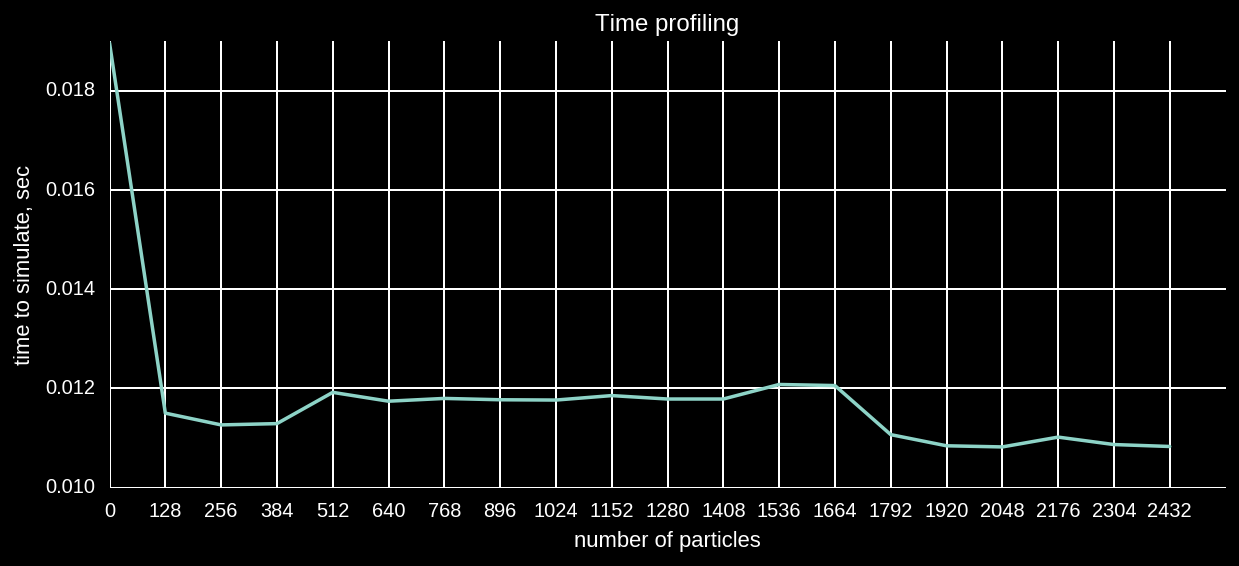

In [0]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
# plt.figure(figsize=(10,6), dpi=80)
plt.style.use(['dark_background'])
gpu_times = np.loadtxt("gpu_times_10.txt")[2:]
plt.figure(figsize=(10,4))
plt.plot(gpu_times);
plt.xlabel("number of particles")
plt.ylabel("time to simulate, sec")
n, step = np.loadtxt("gpu_times_10.txt")[:2]
xticks = np.arange(n)
xlabels = xticks*step
plt.xticks(xticks, xlabels.astype(int))
# plt.xticks(rotation=30)
plt.title("Time profiling");

In [0]:
! ls
! head translations.txt

example2.txt   exeReg10		 tcuda10.cu	   treg100010.cpp
example.txt    exeReg100010	 tcuda200010.cu    treg10.cpp
exeCuda10      exeReg200010	 tcuda300010.cu    treg200010.cpp
exeCuda100010  exeReg300010	 tcuda400010.cu    treg300010.cpp
exeCuda200010  exeReg400010	 tcuda500010.cu    treg400010.cpp
exeCuda300010  exeReg500010	 tcuda600010.cu    treg500010.cpp
exeCuda400010  exeReg600010	 tcuda700010.cu    treg600010.cpp
exeCuda500010  exeReg700010	 tcuda800010.cu    treg700010.cpp
exeCuda600010  exeReg800010	 tcuda900010.cu    treg800010.cpp
exeCuda700010  exeReg900010	 time2.txt	   treg900010.cpp
exeCuda800010  gpu_times_10.txt  time.txt
exeCuda900010  tcuda100010.cu	 translations.txt
5.00261e-07
3.52792e-07
6.61069e-07
6.60785e-07
1.13138e-06
2.74719e-07
4.69673e-07
8.79115e-07
4.43677e-07
9.62929e-07


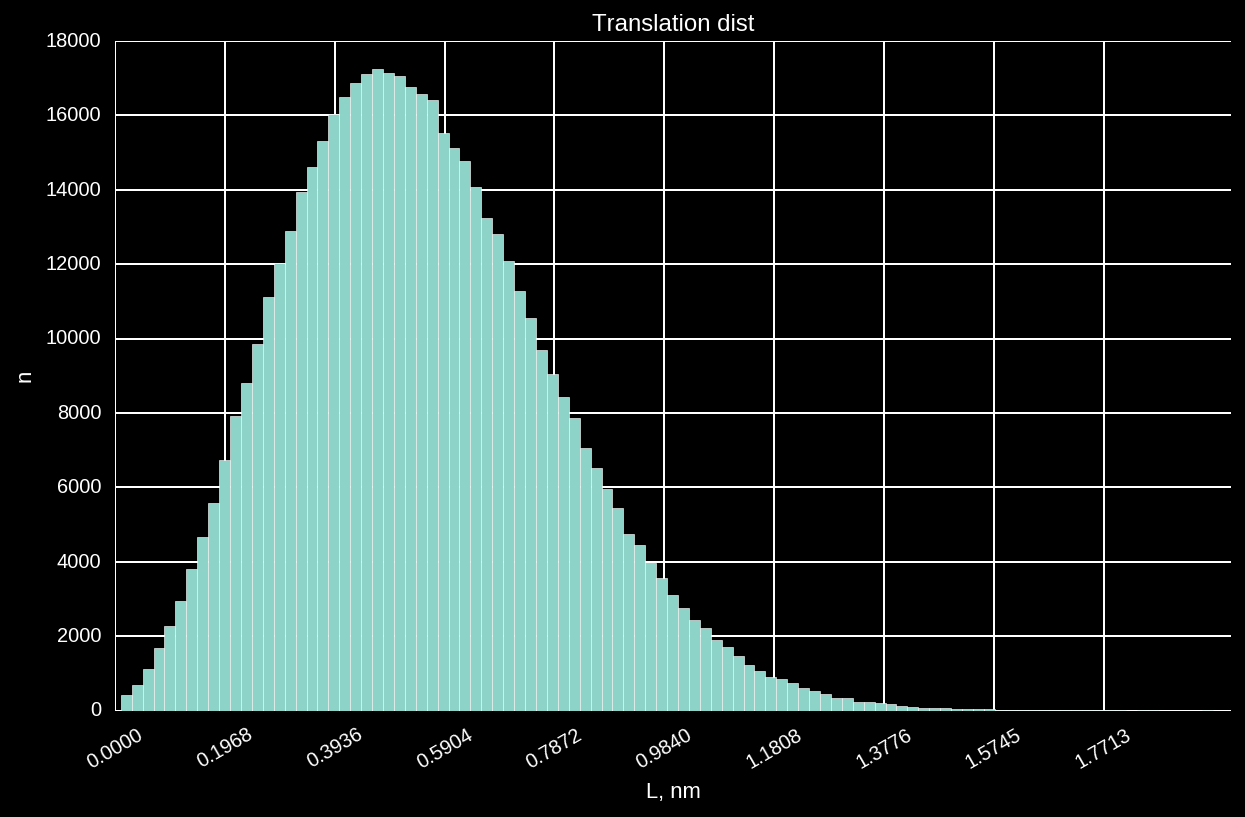

In [0]:
import numpy as np
from matplotlib import pyplot as plt

ress = np.loadtxt("translations.txt")
plt.figure(figsize=(10,6))
h = plt.hist(ress, bins=100);
plt.xlabel("L, nm")
plt.ylabel("n")
xticks = np.max(ress)*np.arange(10)/10
xlabels = [f'{xx:.4f}' for xx in xticks*10e5]
plt.xticks(xticks, xlabels)
plt.xticks(rotation=30)
plt.title("Translation dist");

In [0]:
! wget -q -O screen2.jpg https://i.imgur.com/4wrkIcX.jpg
from google.colab import files
from IPython.display import Image, display, HTML
# display(HTML("<img src='https://i.imgur.com/4wrkIcX.jpg'>"))
# Image("screen2.jpg", width=400)

In [0]:
%%cu
#include <fstream>
#include <iostream>
#include <math.h>
#include <stdlib.h>
#include <time.h>
#include <random>
#include <string>

using namespace std;

double V_func(double x, double par0, double par1, double par2){
    return par0 * par1 * 14.4 / x * par2;
}

double Vshtrih_func(double x, double par0, double par1, double par2, double par3, double par4) {
    return par0 * par1 * 14.4 / x * (par2 / par3 - par4 / x);
}

double FI_func(double x) {
    return 0.1818 * exp(-3.2 * x) + 0.5099 * exp(-0.9432 * x) + 0.2802 * exp(-0.4029 * x) + 0.0282 * exp(-0.2016 * x);
}
double FIshtrih_func(double x) {
    return -(0.1818 * 3.2 * exp(-3.2 * x) + 0.5099 * 0.9432 * exp(-0.9432 * x) + 0.2802 * 0.4029 * exp(-0.4029 * x) + 0.0282 * 0.2016 * exp(-0.2016 * x));
}

double f_func(double x, double par0, double par1, double par2) {
    return 1 - par0 / par1 - (par2 / x) * (par2 / x);
}

double fshtrih_func(double x, double par0, double par1, double par2) {
    return -par0 / par1 + 2 * par2 * par2 / (x * x * x);
}

double sinkvtetanadva(double p, double E, double M1, double M2, int Z1, int Z2) {
    long double a = 0.88534 * 0.529 / (pow(Z1, 0.23) + pow(Z2, 0.23));
    a = a * (-0.003 * (pow(Z1, 0.5) + pow(Z2, 0.5)) + 0.98);

    long double B = p / a;
    long double Ec = E / (1 + M1 / M2);

    long double rm = a;
    double V_out;
    double Vshtrih_out;
    for (int gggg = 0; gggg < 20; gggg++) {
        double FI_out = FI_func(rm / a);
        double FIshtrih_out = FIshtrih_func(rm / a);
        V_out = V_func(rm, Z1, Z2, FI_out);
        Vshtrih_out = Vshtrih_func(rm, Z1, Z2, FIshtrih_out, a, FI_out);
        double fshtrih_out = fshtrih_func(rm, Vshtrih_out, Ec, p);
        double f_out = f_func(rm, V_out, Ec, p);
        rm = rm - f_out / fshtrih_out;
    }
    long double ro = -2 * (Ec - V_out) / Vshtrih_out;
    long double Rm = rm / a;
    long double Rc = ro / a;
    long double Esm = M2 / (M1 + M2) * E;
    long double epsilon = a * Esm / (Z1 * Z2 * 14.4);
    long double alfa = 1 + 0.75984 * pow(epsilon, -0.5);
    long double beta = (5.71974 + pow(epsilon, 0.5)) / (6.14171 + pow(epsilon, 0.5));
    long double gamma = (9.5217 + epsilon) / (6.2612 + epsilon);
    long double A = 2 * alfa * epsilon * pow(B, beta);
    long double G = gamma / (pow((1 + A * A), 0.5) - A);

    long double delta = A * (Rm - B) / (1 + G);

    if (((B + Rc + delta) / (Rm + Rc) < 1) && ((B + Rc + delta) / (Rm + Rc) > -1)) {
        long double theta = 2 * acos((B + Rc + delta) / (Rm + Rc));
        return (sin(theta / 2) * sin(theta / 2));
    } else {
        return 1 / (1 + 2 * epsilon * B * 2 * epsilon * B);
    }
}

default_random_engine generator;
uniform_real_distribution < double > distribution(0.0, 1.0);

int partner(int n, double * w) {

    double wpar[100];
    wpar[0] = w[0];

    for (int i = 1; i < n; i++) {
        wpar[i] = wpar[i - 1] + w[i];
        //cout << wpar[i] << "  ";
    }

    double ksi = distribution(generator);

    int k = 0;
    while (ksi > wpar[k]) k++;

    return (k);
}

int do_interact() {
    
    // gRandom->SetSeed(time(NULL));

    // alpha - C12H18O7
    double M1 = 4, Z1 = 2, E = 150; //aem,keV
    int n = 3;
    double M1m = 12, Z1m = 6; //aem,г/моль
    double M2m = 1, Z2m = 1; //aem,г/моль
    double M3m = 16, Z3m = 8; //aem,г/моль/
    double w[100] = {
        12. / 37,
        18. / 37,
        7. / 37
    };
    double mu[100] = {
        12,
        1,
        16
    };
    double ro = 1.32;

    

    double x0 = 0, y0 = 0, z0 = 0;
    double omegaX1 = 1, omegaY1 = 0, omegaZ1 = 0;
    double omegaX2, omegaY2, omegaZ2;
    double Na = 6.02e23;

    double Mu = 0;

    for (int ta = 0; ta < n; ta++) {
        Mu = Mu + w[ta] * mu[ta];
    }
    double n0 = ro / Mu * Na;
    //cout << "no= " << n0 << " сm^-3" << endl;
    double L = pow(n0, -1. / 3);
    //cout << "L= " << L << " сm" << endl;
    double ksi;
    double M2, Z2;
    double x, y, z;

    int k = 0;
    int z1mi = 0;
    int z2mi = 0;
    int z3mi = 0;

    while (E > 10) {

        ksi = distribution(generator);
        int prtn = partner(n, w);

        if (prtn == 0) {
            Z2 = Z1m;
            M2 = M1m;
            z1mi++;
        }
        // z1toz1m->SetPoint(z1mi,x,y,z); z1toz2m->SetPoint(z2mi,x,y,z); z1toz3m->SetPoint(z3mi,x,y,z);
        if (prtn == 1) {
            Z2 = Z2m;
            M2 = M2m;
            z2mi++;
        }
        if (prtn == 2) {
            Z2 = Z3m;
            M2 = M3m;
            z3mi++;
        }

        ksi = distribution(generator);
        double p = sqrt(ksi / 3.1415 / pow(n0, 2. / 3)) * 1e8;

        double Emax = 4 * M1 * M2 / pow((M1 * M2), 2) * E;
        double skt = sinkvtetanadva(p, E, M1, M2, Z1, Z2);
        //cout << "p= " << p << "A, E= " << E << "keV, M1= " << M1 << " M2= " << M2 << " Z1= " << Z1 << " Z2= " << Z2 << endl;
        //cout << "skt= " << skt << endl;
        double teta = 2 * asin(sqrt(skt));
        double E2 = Emax * skt;

        double alfa = 1.88 / 1000 * pow(Z1 + Z2, 5. / 3) * sqrt(E / M1);
        double beta = 0.3042 * pow((Z1 + Z2), 1. / 3);
        double deltaE = alfa / pow(1 + beta * p, 5);

        double Tetalab = atan(sin(teta) / (cos(teta) + M1 / M2));
        double muuuu = cos(Tetalab);
        ksi = distribution(generator);

        double fi = 2 * 3.1415 * ksi;

        omegaX2 = omegaX1 * muuuu - (omegaY1 * sin(fi) + omegaX1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaY2 = omegaY1 * muuuu + (omegaX1 * sin(fi) - omegaY1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaZ2 = omegaZ1 * muuuu + (1 - omegaZ1 * omegaZ1) * cos(fi) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);

        x = L * omegaX2 + x0;
        y = L * omegaY2 + y0;
        z = L * omegaZ2 + z0;

        k++;

        x0 = x;
        y0 = y;
        z0 = z;
        //cout << "X= " << x << "Y= " << y << "Z= " << z << endl;

        omegaX1 = omegaX2;
        omegaY1 = omegaY2;
        omegaZ1 = omegaZ2;

        E = E - E2 - deltaE;
        //cout << "E= " << E << endl << endl;
    }
    return 0;
}

int time_profiling(int n){
    clock_t t;
    t = clock();
    for (int i=0; i<n; i++){
        do_interact();
    }
    t = clock() - t;
    //cout<<"time: "<<((float)t)/CLOCKS_PER_SEC<<"  ";
    return (int) t;
}

int main(){
    int n = 20;
    int step = 128; //step
    float *times = new float[n];
    int *ns = new int[n];
    int count = 0;
    //cout<<time_profiling(512)<<endl;
    
    ofstream myfile;
    myfile.open ("cpu_times_10.txt");
    myfile<<n<<endl<<step<<endl;
    for (int i=0; i<step*n; i+=step){
        times[count] = ((float)time_profiling(i+1))/CLOCKS_PER_SEC;
        myfile <<times[count]<<endl;
        ns[count] = i;
        count++;
    }
    myfile.close();
    
    /*for (int i=1; i<nn; i*=2){
        cout<<i;
        times[count] = ((float)time_profiling(i))/CLOCKS_PER_SEC;
        ns[count] = i;
        cout<<times[count];
        count++;
    }*/
    delete [] ns;
    delete [] times;
    return 0;
}



''

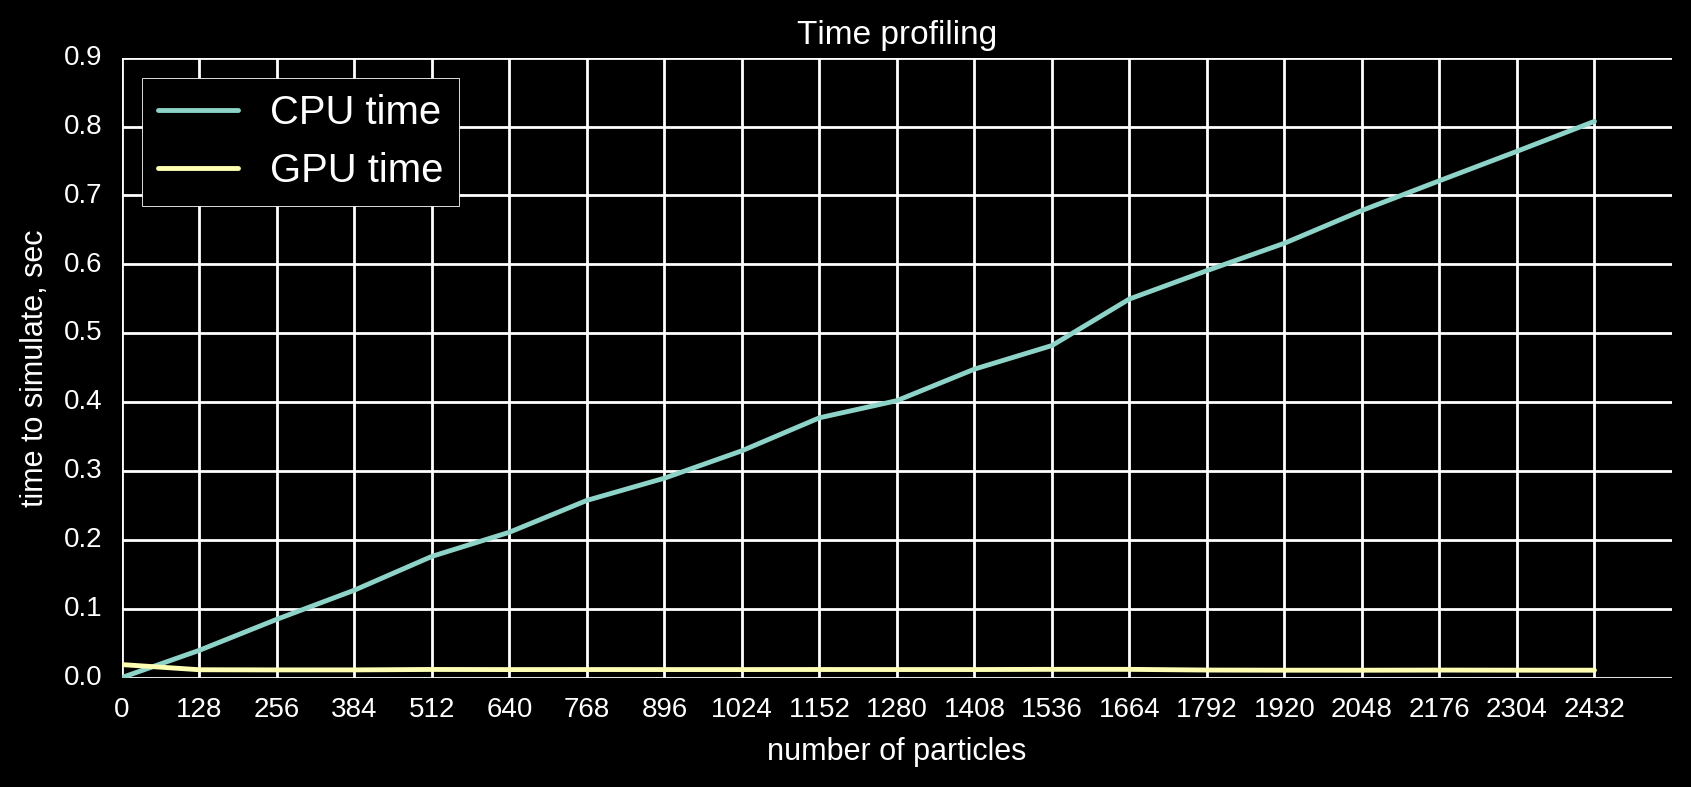

In [0]:
cpu_times = np.loadtxt("cpu_times_10.txt")[2:]
plt.figure(figsize=(10,4), dpi=100)
plt.plot(cpu_times, label="CPU time");
plt.plot(gpu_times, label="GPU time")
plt.xlabel("number of particles")
plt.ylabel("time to simulate, sec")
n, step = np.loadtxt("gpu_times_10.txt")[:2]
xticks = np.arange(n)
xlabels = xticks*step
plt.xticks(xticks, xlabels.astype(int))
# plt.xticks(rotation=30)
plt.title("Time profiling")

plt.legend(loc=2, frameon=True, fontsize='x-large');